In [1]:
from itertools import chain
from random import Random

import anndata as ad
import networkx as nx
import pandas as pd
import scanpy as sc
import scglue
import seaborn as sns
from matplotlib import rcParams

In [2]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

In [3]:
rna = ad.read_h5ad("rna-pp.h5ad")
atac = ad.read_h5ad("atac-pp.h5ad")
guidance = nx.read_graphml("guidance.graphml.gz")

In [4]:
rna.obs_names, atac.obs_names

(Index(['09L_GTTAGAACAGAT_RNA', '09I_CATAGCTCAACG_RNA', '09G_TTACAGGCAGGT_RNA',
        '09B_CTATGGGCGTGC_RNA', '09L_AGTGATTGTTCG_RNA', '09C_ATATGTCTATAA_RNA',
        '09A_CCTATTATTCGA_RNA', '09C_GCGTGCCGAATG_RNA', '09G_AGCTGACGCCGA_RNA',
        '09D_CAGTCCCCAAAT_RNA',
        ...
        '09H_GTTCGCTTGTCG_RNA', '09B_CAGGTGGTCTAT_RNA', '09C_GACCCTGTCGTT_RNA',
        '09I_AACCAATCCTCA_RNA', '09C_AGAGTCTGAAAC_RNA', '09E_CCTGCTCGTCAC_RNA',
        '09E_TGAGCACCTCCT_RNA', '09E_CCGGACTCGATC_RNA', '09F_GCCCGACTCGCA_RNA',
        '09D_ATACTGCGCCCA_RNA'],
       dtype='object', name='cells', length=9190),
 Index(['09L_GTAAACCCGATA_ATAC', '09D_GCCGGGCGGCCG_ATAC',
        '09J_TAGGCCTGAATT_ATAC', '09C_TCCGGCATCTCA_ATAC',
        '09C_AGGCCACGTACA_ATAC', '09E_AAGGGGAGCTGG_ATAC',
        '09K_CCGCCTTATAAT_ATAC', '09A_CGGATGTATCAT_ATAC',
        '09B_TCAGAACTGCTA_ATAC', '09J_TCCGTGATAGAG_ATAC',
        ...
        '09E_TAGTCGCGTACT_ATAC', '09J_GCACCTAAATGA_ATAC',
        '09E_CACCCACGCTCC_ATAC',

In [5]:
rna_deanonym = rna.obs_names.str[:-4]
atac_deanonym = atac.obs_names.str[:-5]
assert set(rna_deanonym) == set(atac_deanonym)  # The original barcodes are fully paired

paired_cells = set(Random(0).sample(set(rna_deanonym), 3000))
rna.obs_names = [
    deanonym if deanonym in paired_cells else anonym
    for anonym, deanonym in zip(rna.obs_names, rna_deanonym)
]
atac.obs_names = [
    deanonym if deanonym in paired_cells else anonym
    for anonym, deanonym in zip(atac.obs_names, atac_deanonym)
]
rna.obs_names, atac.obs_names

/tmp/ipykernel_259184/848656567.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  paired_cells = set(Random(0).sample(set(rna_deanonym), 3000))


(Index(['09L_GTTAGAACAGAT', '09I_CATAGCTCAACG_RNA', '09G_TTACAGGCAGGT_RNA',
        '09B_CTATGGGCGTGC', '09L_AGTGATTGTTCG_RNA', '09C_ATATGTCTATAA',
        '09A_CCTATTATTCGA_RNA', '09C_GCGTGCCGAATG', '09G_AGCTGACGCCGA',
        '09D_CAGTCCCCAAAT_RNA',
        ...
        '09H_GTTCGCTTGTCG', '09B_CAGGTGGTCTAT_RNA', '09C_GACCCTGTCGTT',
        '09I_AACCAATCCTCA_RNA', '09C_AGAGTCTGAAAC', '09E_CCTGCTCGTCAC_RNA',
        '09E_TGAGCACCTCCT', '09E_CCGGACTCGATC', '09F_GCCCGACTCGCA_RNA',
        '09D_ATACTGCGCCCA_RNA'],
       dtype='object', length=9190),
 Index(['09L_GTAAACCCGATA_ATAC', '09D_GCCGGGCGGCCG_ATAC',
        '09J_TAGGCCTGAATT_ATAC', '09C_TCCGGCATCTCA_ATAC',
        '09C_AGGCCACGTACA_ATAC', '09E_AAGGGGAGCTGG_ATAC',
        '09K_CCGCCTTATAAT_ATAC', '09A_CGGATGTATCAT_ATAC',
        '09B_TCAGAACTGCTA_ATAC', '09J_TCCGTGATAGAG_ATAC',
        ...
        '09E_TAGTCGCGTACT_ATAC', '09J_GCACCTAAATGA', '09E_CACCCACGCTCC_ATAC',
        '09G_AACCATACGTTC_ATAC', '09H_TGGCACAAAGGA_ATAC',
        

In [6]:
scglue.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca",
    use_obs_names=True
)

In [7]:
scglue.models.configure_dataset(
    atac, "NB", use_highly_variable=True,
    use_rep="X_lsi",
    use_obs_names=True
)

In [8]:
guidance_hvf = guidance.subgraph(chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
)).copy()

In [9]:
    glue = scglue.models.fit_SCGLUE(
    {"rna": rna, "atac": atac}, guidance_hvf,
    model=scglue.models.PairedSCGLUEModel,
    fit_kws={"directory": "glue"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 3 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] PairedSCGLUEModel: Setting `graph_batch_size` = 27025
[INFO] PairedSCGLUEModel: Setting `max_epochs` = 222
[INFO] PairedSCGLUEModel: Setting `patience` = 19
[INFO] PairedSCGLUEModel: Setting `reduce_lr_patience` = 10
[INFO] PairedSCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] PairedSCGLUETrainer: [Epoch 10] train={'g_nll': 0.454, 'g_kl': 0.004, 'g_elbo': 0.459, 'x_rna_nll': 0.166, 'x_rna_kl': 0.007, 'x_rna_elbo': 0.173, 'x_atac_nll': 0.04, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.041, 'dsc_loss': 0.692, 'vae_loss': 0.244, 'gen_loss': 0.209, 'joint_cross_loss': 0.206, 'real_cross_loss': 0.212, 'cos_loss': 0.134}, val={'g_nll': 0.451, 'g_kl': 0.005, 'g_elbo': 0.455, 'x_rna_nll': 0.166

2023-07-21 14:59:40,464 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "60"...
[INFO] EarlyStopping: Restoring checkpoint "60"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...


/mnt/disk1/jkxiao/code/Anaconda/envs/scGLUE/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/disk1/jkxiao/code/Anaconda/envs/scGLUE/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/disk1/jkxiao/code/Anaconda/envs/scGLUE/lib/pyth

[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (18, 19)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] PairedSCGLUEModel: Setting `graph_batch_size` = 27025
[INFO] PairedSCGLUEModel: Setting `align_burnin` = 37
[INFO] PairedSCGLUEModel: Setting `max_epochs` = 222
[INFO] PairedSCGLUEModel: Setting `patience` = 19
[INFO] PairedSCGLUEModel: Setting `reduce_lr_patience` = 10
[INFO] PairedSCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] PairedSCGLUETrainer: [Epoch 10] train={'g_nll': 0.415, 'g_kl': 0.004, 'g_elbo': 0.419, 'x_rna_nll': 0.16, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.167, 'x_atac_nll': 0.039, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.04, 'dsc_loss': 

2023-07-21 15:12:39,926 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "122"...
[INFO] EarlyStopping: Restoring checkpoint "122"...


In [10]:
dx = scglue.models.integration_consistency(
    glue, {"rna": rna, "atac": atac}, guidance_hvf
)
dx

[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/mnt/disk1/jkxiao/code/Anaconda/envs/scGLUE/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/mnt/disk1/jkxiao/code/Anaconda/envs/scGLUE/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/mnt/disk1/jkxiao/code/Anaconda/envs/scGLUE/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/mnt/disk1/jkxiao/code/Anaconda/envs/scGLUE/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/mnt/disk1/jkxiao/code/Anaconda/envs/scGLUE/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...


,n_meta,consistency
0,10,0.186644
1,20,0.138752
2,50,0.107378
3,100,0.085708
4,200,0.066844


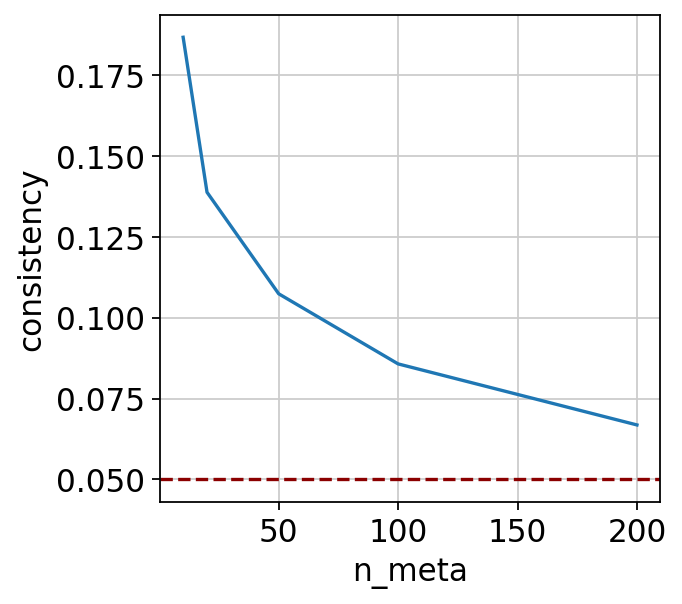

In [11]:
_ = sns.lineplot(x="n_meta", y="consistency", data=dx).axhline(y=0.05, c="darkred", ls="--")

In [12]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

In [13]:
combined = ad.concat([rna, atac])

/mnt/disk1/jkxiao/code/Anaconda/envs/scGLUE/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/mnt/disk1/jkxiao/code/Anaconda/envs/scGLUE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/mnt/disk1/jkxiao/code/Anaconda/envs/scGLUE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


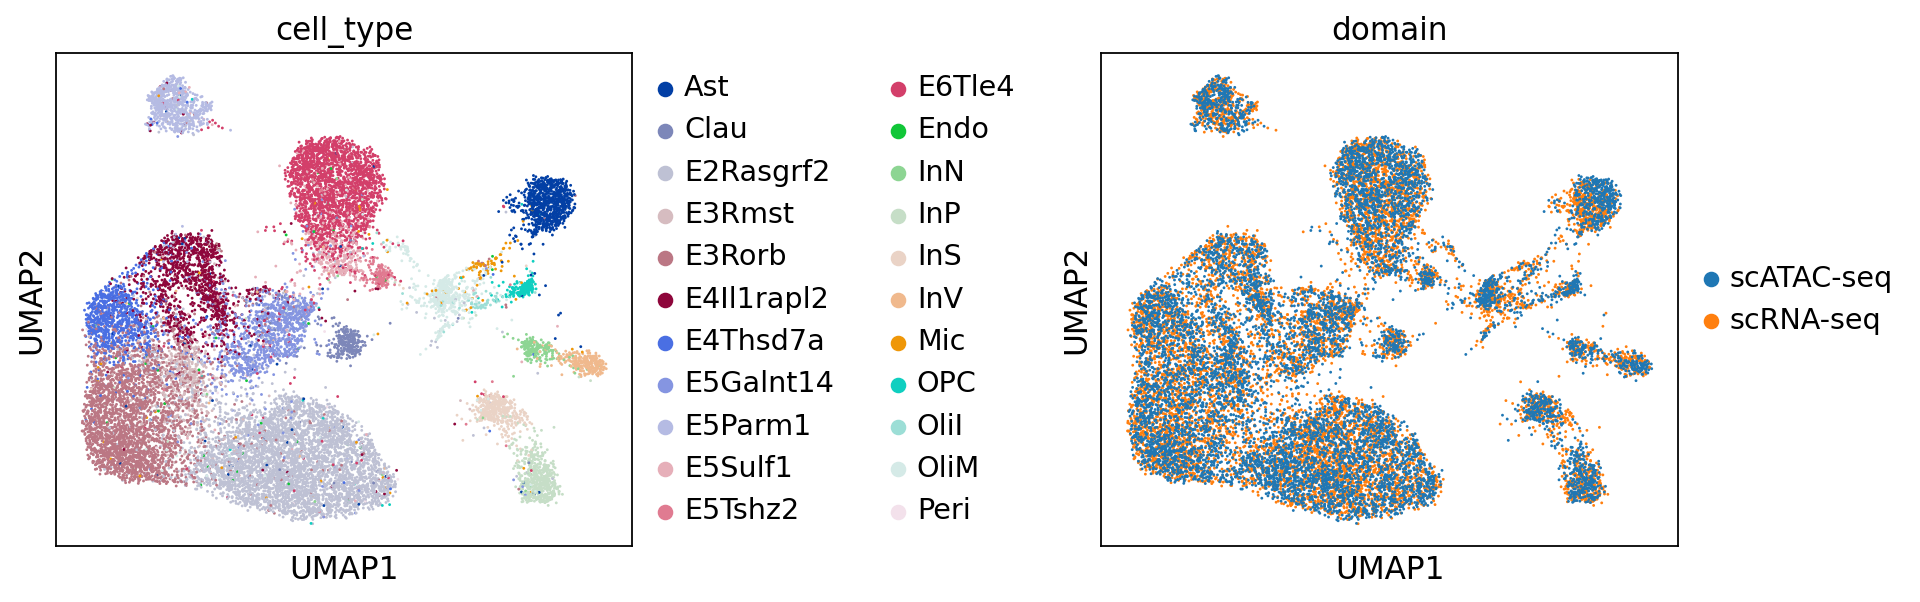

In [14]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)
sc.pl.umap(combined, color=["cell_type", "domain"], wspace=0.65)

In [15]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

,0,1,2,3,4
0610009B22Rik,-0.195698,0.101652,0.001220,0.491726,1.127905
0610025J13Rik,0.024427,0.235634,-0.002547,-0.061092,1.742736
1110002J07Rik,0.186738,-0.430060,-0.001416,-0.452736,1.419992
1110006O24Rik,-0.321845,-0.018377,-0.000366,0.195551,1.410669
1110020A21Rik,0.268093,-0.032404,-0.003580,-0.060738,1.504989


In [16]:
rna.varm["X_glue"] = feature_embeddings.reindex(rna.var_names).to_numpy()
atac.varm["X_glue"] = feature_embeddings.reindex(atac.var_names).to_numpy()